In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
praveengovi_emotions_dataset_for_nlp_path = kagglehub.dataset_download('praveengovi/emotions-dataset-for-nlp')

print('Data source import complete.')


Using Colab cache for faster access to the 'emotions-dataset-for-nlp' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from transformers import BertTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# nltk downloads and stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")
lemmatizer= WordNetLemmatizer()
nltk.download('wordnet', download_dir = '/root/nltk_data/')
nltk.download('omw-1.4', download_dir = '/root/nltk_data/')
# !unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/
# !unzip /root/nltk_data/corpora/omw-1.4.zip -d /root/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data/...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Datasets**

In [ ]:
# Read datasets
df_train = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['Text', 'Emotion'], sep=';')

In [ ]:
# Read datasets
df_train = pd.read_csv(f'{praveengovi_emotions_dataset_for_nlp_path}/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv(f'{praveengovi_emotions_dataset_for_nlp_path}/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv(f'{praveengovi_emotions_dataset_for_nlp_path}/test.txt', names=['Text', 'Emotion'], sep=';')

In [ ]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
#print the shape of the data set
print(df_train.shape)

(16000, 2)


In [ ]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
#print the shape of the data set
print(df_test.shape)

(2000, 2)


In [ ]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [ ]:
#print the shape of the data set
print(df_val.shape)

(2000, 2)


# **Cleaning & Visualization**

## Train dataset

In [ ]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

,count
Emotion,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [ ]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

,count
Emotion,
joy,33.51250
sadness,29.16250
anger,13.49375
fear,12.10625
love,8.15000
surprise,3.57500


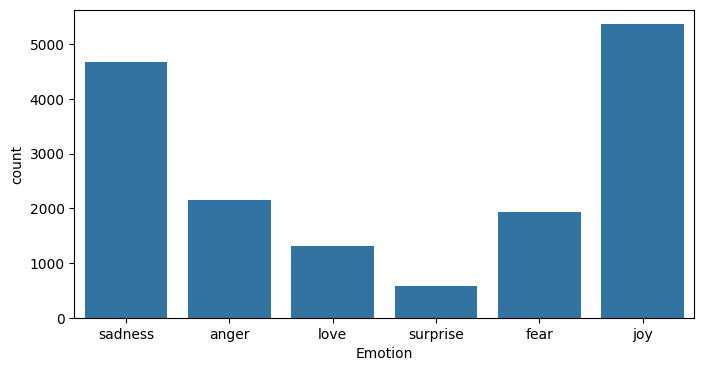

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

In [ ]:
#print the number of null values in each column
df_train.isnull().sum()

,0
Text,0
Emotion,0


In [ ]:
#print the number of duplicated values
df_train.duplicated().sum()

np.int64(1)

In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [ ]:
#print some of those rows to check
df_train[df_train['Text'] == df_train['Text'].iloc[5067]]

,Text,Emotion
1501,i feel on the verge of tears from weariness i ...,love
5067,i feel on the verge of tears from weariness i ...,joy


In [ ]:
df_train[df_train['Text'] == df_train['Text'].iloc[13879]]

,Text,Emotion
7333,i feel like i am very passionate about youtube...,joy
13879,i feel like i am very passionate about youtube...,love


In [ ]:
#removing duplicated text
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

## Test dataset

In [ ]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

,count
Emotion,
joy,695
sadness,581
anger,275
fear,224
love,159
surprise,66


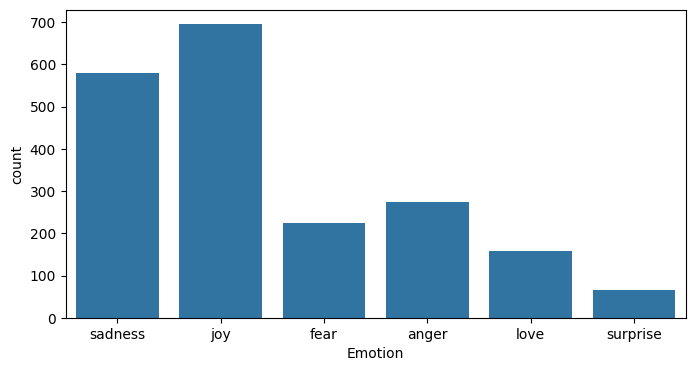

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [ ]:
#print the number of null values in each column
df_test.isnull().sum()

,0
Text,0
Emotion,0


In [ ]:
#print the number of duplicated values
df_test.duplicated().sum()

np.int64(0)

In [ ]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]

,Text,Emotion


## Validation dataset

In [ ]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

,count
Emotion,
joy,704
sadness,550
anger,275
fear,212
love,178
surprise,81


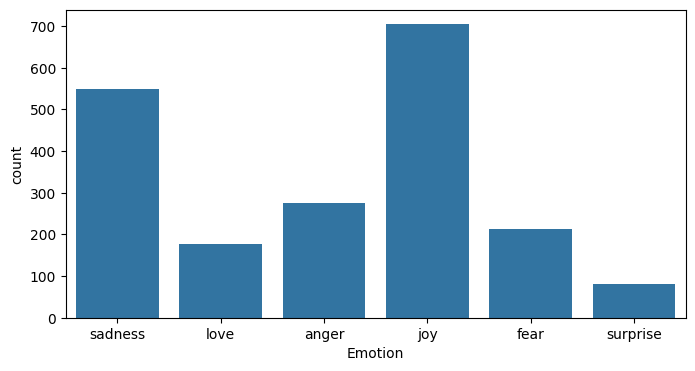

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [ ]:
#print the number of null values in each column
df_val.isnull().sum()

,0
Text,0
Emotion,0


In [ ]:
#print the number of duplicated values
df_val.duplicated().sum()

np.int64(0)

In [ ]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [ ]:
df_val[df_val['Text'] == df_val['Text'][603]]

,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [ ]:
df_val[df_val['Text'] == df_val['Text'][1993]]

,Text,Emotion
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [ ]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

# **Natural Language Processing**

In [ ]:
# Function to convert NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def normalize_text(input_data):
    # Remove URLs and any trailing spaces after them
    text = re.sub(r'https?://\S+|www\.\S+', '', input_data)

    # Remove non-alphabetic characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove extra spaces caused by URL removal
    text = re.sub(r'\s+', ' ', text).strip()

    # Check word count and return NaN if less than 3 words
    if len(text.split()) < 3:
        text = np.nan

    # Remove stop words
    text = " ".join(i for i in str(text).split() if i not in stop_words)

    # Get POS tags
    text = text.split()
    # Download the missing resource
    nltk.download('averaged_perceptron_tagger_eng')
    pos_tags = pos_tag(text)

    # Execute lemmatizer
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    #lemitizer without position tags
    # text = text.split()
    # text = [lemmatizer.lemmatize(y) for y in text]

    return " ".join(text)

a = 'The leaves are falling from the trees, and the children are running happily.'
normalize_text(a)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


'leaf fall tree child run happily'

In [69]:
df_train['Text'] = df_train['Text'].apply(normalize_text)
df_test['Text'] = df_test['Text'].apply(normalize_text)
df_val['Text'] = df_val['Text'].apply(normalize_text)

Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already 

In [ ]:
# Checking nan counts
print(f"train nan count: {(df_train['Text'] == 'nan').sum()}")
print(f"test nan count: {(df_test['Text'] == 'nan').sum()}")
print(f"val nan count: {(df_val['Text'] == 'nan').sum()}")

train nan count: 8
test nan count: 0
val nan count: 1


In [ ]:
#removing nan rows
def remove_nan(data):
    index = data[data['Text'] == 'nan'].index
    data.drop(index, axis = 0, inplace = True)
    data.reset_index(inplace=True, drop = True)

# Applying data to remove_nan
remove_nan(df_train)
remove_nan(df_test)
remove_nan(df_val)

In [ ]:
# Checking nan counts
print(f"train nan count: {(df_train['Text'] == 'nan').sum()}")
print(f"test nan count: {(df_test['Text'] == 'nan').sum()}")
print(f"val nan count: {(df_val['Text'] == 'nan').sum()}")

train nan count: 0
test nan count: 0
val nan count: 0


In [ ]:
# Encoding target column
# def encoding(data):
#     mapping = {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}
#     data['Emotion'] = data['Emotion'].map(mapping)

# encoding(df_train)
# encoding(df_test)
# encoding(df_val)

# **Text Preprocessing**

In [ ]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [ ]:
# Reshaping Labels to 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [ ]:
# Encoding target column using OHE
encoder = OneHotEncoder(sparse_output=False)

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

In [ ]:
# Find the number of words in a document
train_length = df_train['Text'].apply(lambda x: len(x.split()))
test_length = df_test['Text'].apply(lambda x: len(x.split()))
val_length = df_val['Text'].apply(lambda x: len(x.split()))

# Print statistics for the training set
print(f"train_max : {train_length.max()}")  # Maximum number of words in a document
print(f"train_mean : {train_length.mean()}")  # Average number of words per document
print(f"train_95th_percentile : {np.percentile(train_length, 95)}\n")  # 95th percentile (cutoff for 95% of data)

# Print statistics for the test set
print(f"test : {test_length.max()}")  # Maximum number of words in a document
print(f"test_mean : {test_length.mean()}")  # Average number of words per document
print(f"test_95th_percentile : {np.percentile(test_length, 95)}\n")  # 95th percentile for test set

# Print statistics for the validation set
print(f"val : {val_length.max()}")  # Maximum number of words in a document
print(f"val_mean : {val_length.mean()}")  # Average number of words per document
print(f"val_95th_percentile : {np.percentile(val_length, 95)}\n")  # 95th percentile for validation set

train_max : 35
train_mean : 9.359000062652717
train_95th_percentile : 20.0

test : 31
test_mean : 9.3015
test_95th_percentile : 19.0

val : 31
val_mean : 9.208813219829745
val_95th_percentile : 19.0



In [ ]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# def token(data):
#     return tokenizer(
#         data.tolist(),
#         padding=True,
#         truncation=True,
#         max_length=20,
#         return_tensors="tf")


# X_train = token(X_train)
# X_test = token(X_test)
# X_val = token(X_val)

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Learn vocabulary from training data

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

# Padding (make all sequences the same length)
max_length = 20  # You can change this based on your dataset

X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')

print("Vocabulary Size:", len(tokenizer.word_index))  # Check vocab size
print("First Training Sequence:", X_train[0])  # Example padded sequence

Vocabulary Size: 12358
First Training Sequence: [ 58   2 567   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
X_train

array([[  58,    2,  567, ...,    0,    0,    0],
       [   8,    5,  375, ...,    0,    0,    0],
       [   4, 1351,  380, ...,    0,    0,    0],
       ...,
       [   2,  200,   32, ...,    0,    0,    0],
       [   2,    3,  431, ...,    0,    0,    0],
       [   9,   62,    2, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_test

array([[   4,    2,  106, ...,    0,    0,    0],
       [   4, 1544,  123, ...,    0,    0,    0],
       [  61,    7, 1745, ...,    0,    0,    0],
       ...,
       [   2,  391,   18, ...,    0,    0,    0],
       [   4,    2,  276, ...,    0,    0,    0],
       [   2,  159,  302, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_val

array([[  4,   2,  70, ...,   0,   0,   0],
       [  2,   3,  22, ...,   0,   0,   0],
       [  2,   3, 490, ...,   0,   0,   0],
       ...,
       [  2, 182, 152, ...,   0,   0,   0],
       [298,   2, 189, ...,   0,   0,   0],
       [  2,   3, 859, ...,   0,   0,   0]], dtype=int32)

# **LSTM - Model Training**

In [ ]:
# Define the model
model = Sequential()
model.add(Input(shape=(20,)))
model.add(Embedding(10000, 200, trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 200)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 512)        │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 20, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,102 (15.21 MB)

 Trainable params: 1,988,102 (7.58 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

In [ ]:
# Training the model on the training dataset
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    batch_size=256,
                    validation_data=(X_val,y_val),
                    callbacks=[early_stopping])

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.3055 - loss: 1.6895 - val_accuracy: 0.3630 - val_loss: 1.5699
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3652 - loss: 1.5540 - val_accuracy: 0.4111 - val_loss: 1.5172
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4001 - loss: 1.5141 - val_accuracy: 0.4467 - val_loss: 1.4597
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4485 - loss: 1.4104 - val_accuracy: 0.4727 - val_loss: 1.3776
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5225 - loss: 1.2665 - val_accuracy: 0.5608 - val_loss: 1.1695
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5857 - loss: 1.0975 - val_accuracy: 0.6500 - val_loss: 0.9444
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6466 - loss: 0.9433 - val_accuracy: 0.6925 - val_loss: 0.8481
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6950 - loss: 0.8216 - val_accuracy: 0.7396 - v

In [ ]:
# Taking best epoch values
def best_epoch(value):
    best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
    best_epoch = history.history[value][best_epoch_index]
    print(f"{value}: {best_epoch}")
    return f"epoch no: {best_epoch_index+1}"

best_epoch('accuracy')
best_epoch('loss')
best_epoch('val_accuracy')
best_epoch('val_loss')

accuracy: 0.9265710115432739
loss: 0.18899768590927124
val_accuracy: 0.8898347616195679
val_loss: 0.2831355929374695


'epoch no: 19'

# **Model Evaluation & Visualization**

In [ ]:
# Test Accuracy and Loss
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8700 - loss: 0.3035
Test Accuracy: 0.8755
Test Loss: 0.3137


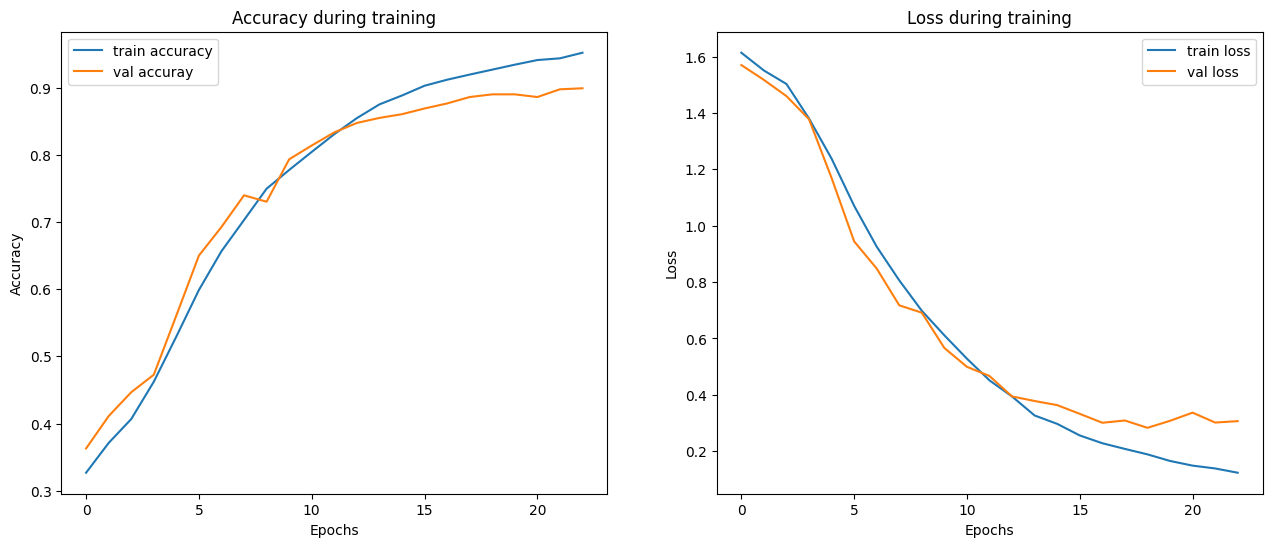

In [ ]:
# Model Performance Visualization
plt.figure(figsize=(15.5, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuray')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step


In [ ]:
# Model Evaluation - Classification Metrics
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       275
           1       0.85      0.86      0.86       224
           2       0.87      0.94      0.90       695
           3       0.76      0.67      0.71       159
           4       0.94      0.88      0.91       581
           5       0.67      0.65      0.66        66

    accuracy                           0.88      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.88      0.88      0.87      2000



In [ ]:
encoder.categories_

[array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object)]

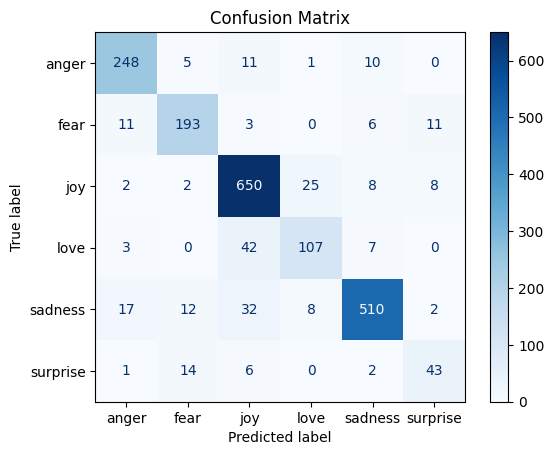

In [ ]:
# Model Evaluation - Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()